# 生成模拟数据

In [8]:
import os
path = 'd:\\img\\ocr'
txt_file_name = os.path.join(path,'hand','char_words.txt')
fonts_path = os.path.join(path, 'fonts')
output_path = os.path.join(path,'hand','train')
b_image_path = os.path.join(path, 'background')
img_height = 32
img_width = 100


In [56]:
# 生成字符
import lib.gen_image as gen
import importlib
importlib.reload(gen)



alpha = 'ABQP'
gen.gen_words(txt_file_name, alpha,max_number=4, total=200)


In [166]:
# 生成训练图片
import lib.gen_image as gen
import os
import numpy as np
import random
import importlib
import shutil
import cv2
importlib.reload(gen)

# 清空目录
shutil.rmtree(output_path)  
os.mkdir(output_path) 

# 字体
all_fonts = []
all_fonts_name = []
for root, dirs, files in os.walk(fonts_path):
    for file in files:
        if file.endswith(".ttf"):
            all_fonts.append(os.path.join(root, file))
            all_fonts_name.append(file[:-4])
            
with open(txt_file_name) as f:
    text_lines = f.readlines()
text_lines = [t.strip() for t in text_lines]
text_lines = [t for t in text_lines if len(t) > 0]

bg_file_lists = [os.path.join(b_image_path, x) for x in os.listdir(b_image_path)]
text_set = [[32, 100, [20,24]],[64,200,[30,28]],[48,150,[26,24]]]
number_of_examples = 100



image_list = []
output_data =[]

for i, txt in enumerate(random.sample(text_lines, number_of_examples)):
    select_font_idx = np.random.randint(len(all_fonts))
    img_height, img_width, font_size_list = text_set[np.random.randint(len(text_set))]
    font_size = font_size_list[np.random.randint(len(font_size_list))]
    image = gen.make_image(test_str=txt, fonttype=all_fonts[select_font_idx], 
                         fontsize=font_size,target_width=img_width, target_height=img_height, 
                         back_ground_img_list=bg_file_lists, 
                         need_include=True)
#     print('image size -->', image.shape)
    img_path = os.path.join(output_path, str(i)+'_'+all_fonts_name[select_font_idx] + ".png")
#     image_list.append(image)
    cv2.imwrite(img_path, image)    
    txt = txt.replace('＋','+')
    txt = txt.replace('－','-')
    txt = txt.replace('（','(')
    txt = txt.replace('）',')')
    output_data.append({
        "image_path": "{}_{}.png".format(str(i), all_fonts_name[select_font_idx]),
        "gt": txt.lower()
    })    
            
train_cnt = int(number_of_examples * 1.0)
val_cnt = number_of_examples - train_cnt
with open(os.path.join(path,'hand', 'training.json'), 'w') as f:
    json.dump(output_data[:train_cnt], f)

with open(os.path.join(path,'hand', 'validation.json'), 'w') as f:
    json.dump(output_data[train_cnt:], f)

print('over')


over


In [167]:
# 生成训练库
import json
from lib.gen_dataset import createDataset
import os
img_path = os.path.join(path,'hand','train')
train_file = os.path.join(path, 'hand','training.json') 
valid_file = os.path.join(path, 'hand','validation.json') 
with open(train_file,'r') as f:
    train_data = json.load(f)
    
imgLabelLists = []
for item in train_data:
    imgLabelLists.append((os.path.join(path,'hand','train',item['image_path']) ,str(item['gt'])))

random.shuffle(imgLabelLists)
train_lmdb_path = os.path.join(path,'hand','lmdb')   # 训练数据
trainImgPaths = [x[0] for x in imgLabelLists]
trainTxtLists = [x[1] for x in imgLabelLists]
createDataset(train_lmdb_path, trainImgPaths, trainTxtLists, lexiconList=None, checkValid=True)
    

samples length -- > 100
Created dataset with 100 samples


In [168]:
# traindata loader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import lib.dataset as dataset
import lib.utils as utils
import time
import importlib
importlib.reload(dataset)
importlib.reload(utils)

batch_size = 100

train_dataset = dataset.lmdbDataset(root= os.path.join(path,'hand','lmdb'))
# print('train data set length -->{}'.format(len(train_dataset)))
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [int(0.9*len(train_dataset)), 
                                                    int(0.1*len(train_dataset))])


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True,
    collate_fn=dataset.adjustCollate(imgH=32, keep_ratio=False))
#     

for step, values in enumerate(train_loader):
    images = Variable(values[0].type(torch.FloatTensor), requires_grad=False)
#     images = values[0]
    print('step -->', images.size(), '-->', len(images))
    break

print('over')


step --> torch.Size([90, 3, 32, 115]) --> 90
over


In [162]:
images[0]

tensor([[[0.0667, 0.0667, 0.0745,  ..., 1.0000, 1.0000, 1.0000],
         [0.0667, 0.0667, 0.0745,  ..., 1.0000, 1.0000, 1.0000],
         [0.0745, 0.0745, 0.0745,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0980, 0.0980, 0.0980,  ..., 1.0000, 1.0000, 1.0000],
         [0.0980, 0.0980, 0.0980,  ..., 1.0000, 1.0000, 1.0000],
         [0.0980, 0.0980, 0.0980,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0745, 0.0745, 0.0824,  ..., 1.0000, 1.0000, 1.0000],
         [0.0745, 0.0745, 0.0824,  ..., 1.0000, 1.0000, 1.0000],
         [0.0824, 0.0824, 0.0824,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1059, 0.1059, 0.1059,  ..., 1.0000, 1.0000, 1.0000],
         [0.1059, 0.1059, 0.1059,  ..., 1.0000, 1.0000, 1.0000],
         [0.1059, 0.1059, 0.1059,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0588, 0.0588, 0.0667,  ..., 1.0000, 1.0000, 1.0000],
         [0.0588, 0.0588, 0.0667,  ..., 1.0000, 1.0000, 1.0000],
         [0.0667, 0.0667, 0.0667,  ..., 1.0000, 1.0000, 1.

In [55]:
# image 统一长度
PADDING_CONSTANT = 255
assert len(set([b.shape[0] for b in image_list])) == 1
assert len(set([b.shape[2] for b in image_list])) == 1

dim0 = image_list[0].shape[0]
dim1 = max([b.shape[1] for b in image_list])
dim2 = image_list[0].shape[2]

image_list_new = np.full((len(image_list), dim0, dim1, dim2), PADDING_CONSTANT).astype(np.long)
print(len(image_list_new))
for idx, image in enumerate(image_list_new):
    image[:,:image_list[idx].shape[1],:] = image_list[idx]
    img_path = os.path.join(output_path, str(idx)+'_'+all_fonts_name[idx%len(all_fonts)] + ".png")
    cv2.imwrite(img_path, image)   
    

100


# opencv 文本检测

(83, 565, 3)


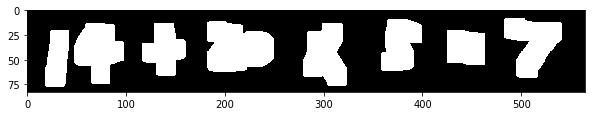

In [33]:
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5

image = cv2.imread('d:\\img\\exam\\mh_1.png')
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,15)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)

plt.imshow(dilate,'gray')
plt.show()